Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**Make a copy of this notebook!**


In [ ]:
#@title Python imports
import collections
import datetime
from functools import partial
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from IPython.display import display, Math
import sympy

In [ ]:
# Make colab plots larger
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [ ]:
# Functions to display matrices nicely

def matrix_to_latex(a):
  return sympy.latex(sympy.Matrix(np.round(a, 3)))

def display_latex(s, newline=True):
  display(Math(s))
  if newline:
    print()

## Jax

[Autodiff cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html)

Jax is a python library that provides the ability to differentiate many python
functions.


In [ ]:
import jax
import jax.numpy as jnp
from jax import jit, grad, vmap, api, random, jacfwd, jacrev
from jax.experimental import optimizers, stax

# Section 1: Multivariate Chain Rules

In this section we'll cover:

* Using Jax
* Multivariate chain rule examples

## Jacobians and Chain rules

Let's verify the chain rule for some examples similar to those from the slides.

### Single variable

First let's simply try a single variable example.
$$ y = \sqrt{x^2+1} = f(g(x))$$

where

$$ f(x) = \sqrt{x}$$

and 

$$g(x) = x^2+1$$

Let's compute the derivatives with Jax. The chain rule is:

$$ \frac{dy}{dx} = \frac{df}{dg} \frac{dg}{dx}$$

In this case all the inputs and outputs are scalars so the multiplication of the derivatives is just ordinary scalar multiplication.

In [ ]:
# Define our functions

def f(x):
  return jnp.sqrt(x)

def g(x):
  return x*x + 1

def y(x):
  return f(g(x))

# We'll use x0 as our point so as not to over use the letter x
x0 = 1.

# Compute the gradient functions.
dy_dx = jacfwd(y)
dg_dx = jacfwd(g)
df_dg = jacfwd(f)

# Compute the values and print
display_latex(r"\frac{{d y}}{{d x}}({}) = {}".format(x0, dy_dx(x0)))
display_latex(r"\frac{{dg}}{{dx}}({}) = {}".format(x0, dg_dx(x0)))
display_latex(r"\frac{{\partial f}}{{dx}} ({}) = {}".format(g(x0), df_dg(g(x0))))
display_latex(r"{} * {} = {}".format(dg_dx(x0), df_dg(g(x0)), np.dot(dg_dx(x0), df_dg(g(x0)))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

So we see that JAX gets the same answer by computing the derivative of the composite or by multiplying together the two component derivatives.

### Try it out
Feel free to experiment with other functions and compositions.

Need an idea? Try a sigmoid like

$$f(x) = \frac{1}{1 + e^{-2x}}$$

In [ ]:
# Experiments here!

def f(x):
  # Your outer function
  pass

def g(x):
  # Your inner function
  pass

def y(x):
  # The composite
  return f(g(x))

# Copy the derivatives code from the above cells


In [ ]:
# @title Solution (double click to show)

def f(x):
  return 1. / (1 + jnp.exp(x))
  pass

def g(x):
  # Your inner function
  return -2 * x

def y(x):
  # The composite
  return f(g(x))

# We'll use x0 as our point so as not to over use the letter x
x0 = 0.

# Compute the gradient functions.
dy_dx = jacfwd(y)
dg_dx = jacfwd(g)
df_dg = jacfwd(f)

# Compute the values and print
display_latex(r"\frac{{d y}}{{d x}}({}) = {}".format(x0, dy_dx(x0)))
display_latex(r"\frac{{dg}}{{dx}}({}) = {}".format(x0, dg_dx(x0)))
display_latex(r"\frac{{\partial f}}{{dx}} ({}) = {}".format(g(x0), df_dg(g(x0))))
display_latex(r"{} * {} = {}".format(dg_dx(x0), df_dg(g(x0)), np.dot(dg_dx(x0), df_dg(g(x0)))))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Multivariate

Now let's try a multivariate example. Consider the function

$$z = f(x, y) = e^{(x^2 - y^2) / 4}$$

and suppose that $x$ and $y$ are themselves functions of $s$ and $t$:

$$x = g(s, t) = s + t$$
$$y = h(s, t) = s - t$$

Let's compute the two partial derivatives

$$\frac{\partial f}{\partial s} = \frac{\partial f}{\partial x} \frac{\partial x}{\partial s} + \frac{\partial f}{\partial y} \frac{\partial y}{\partial s}$$

$$\frac{\partial f}{\partial t} = \frac{\partial f}{\partial x} \frac{\partial x}{\partial t} + \frac{\partial f}{\partial y} \frac{\partial y}{\partial t}$$

First let's define the functions and compute the partial derivative with respect to $t$.

In [ ]:
def f(x, y):
  return jnp.exp((x*x - y*y)/4)

def g(s, t):
  return s + t

def h(s, t):
  return s - t

# We'll use z for the composite so as not to define f twice in code

def z(s, t):
  return f(g(s, t), h(s, t))


Now we can compute the partial

$$\frac{\partial z}{\partial s}$$

at some example values.

In [ ]:
# Use JAX to get the Jacobian, which in this case is again a function that returns
# a scalar value
# argnums=0 gives us the partial with respect to the first variable
dz_ds = jacfwd(z, argnums=0)

for s, t in [(1., 0.), (0., 1.), (1., 1.)]:
  display_latex(r"\frac{{\partial z}}{{\partial s}}({}, {}) = {}".format(s, t, dz_ds(s, t)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's compare to the right-hand-side of the partial formula:

$$\frac{\partial f}{\partial s} = \frac{\partial f}{\partial x} \frac{\partial x}{\partial s} + \frac{\partial f}{\partial y} \frac{\partial y}{\partial s}$$


In [ ]:
dz_dx = jacfwd(f, argnums=0)
dx_ds = jacfwd(g, argnums=0)

dz_dy = jacfwd(f, argnums=1)
dy_ds = jacfwd(h, argnums=0)

for s, t in [(1., 0.), (0., 1.), (1., 1.)]:
  x_ = g(s, t)
  y_ = h(s, t)
  dz_ds = dz_dx(x_, y_) *  dx_ds(s, t) + dz_dy(x_, y_) * dy_ds(s, t)
  display_latex(r"\frac{{\partial z}}{{\partial s}}({}, {}) = {}".format(s, t, dz_ds))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Same results!

## Exercise

Compute $\frac{\partial z}{\partial t}$ both ways as above.

In [ ]:
# Your code here (copy and modify the above code cells)

In [ ]:
# @title Solution (double click to show)

# Use JAX to get the Jacobian, which in this case is a function that returns
# a scalar value
# argnums=0 gives us the partial with respect to the first variable
dz_dt = jacfwd(z, argnums=1)

for s, t in [(1., 0.), (0., 1.), (1., 1.)]:
  display_latex(r"\frac{{\partial z}}{{\partial s}}({}, {}) = {}".format(t, s, dz_dt(s, t)))


dz_dx = jacfwd(f, argnums=0)
dx_dt = jacfwd(g, argnums=1)

dz_dy = jacfwd(f, argnums=1)
dy_dt = jacfwd(h, argnums=1)

for s, t in [(1., 0.), (0., 1.), (1., 1.)]:
  x = g(s, t)
  y = h(s, t)
  dz_dt = dz_dx(x, y) *  dx_dt(s, t) + dz_dy(x, y) * dy_dt(s, t)
  display_latex(r"\frac{{\partial z}}{{\partial s}}({}, {}) = {}".format(s, t, dz_dt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Example

Let's do another example, this time with more inputs.

$$ z = f(\textbf{x}) = x_1^2 + \cdots + x_n^2$$

with

$$ x = g(t) = (t, 2t, \ldots, nt)$$

Now we compute both sides of

$$\frac{df}{dt} = \frac{\partial f}{\partial \mathbf{x}} \frac{\partial x}{\partial t}$$

On an actual point $t_0$, note carefully the arguments on which the Jacobians are evaluated:

$$\frac{df}{dt}(t_0) = \frac{\partial f}{\partial \mathbf{x}}(x(t_0)) \frac{\partial x}{\partial t}(t_0)$$

In [ ]:
# Fix the dimension
n = 4

def f(x):
  return jnp.sum(x * x)

def g(t):
  return t * np.array([i for i in range(1, n+1)])

def h(t):
  return f(g(t))

# Compute the partials
t = 1.
dz_dx = jacfwd(f)
dx_dt = jacfwd(g)
dh_dt = jacfwd(h)

display_latex(r"\frac{{d f}}{{d t}}({}) = {}".format(t, dh_dt((t))))
display_latex(r"\frac{{\partial \mathbf{{x}}}}{{\partial t}}({}) = {}".format(t, dx_dt(t)))
display_latex(r"\frac{{\partial f}}{{\partial \mathbf{{x}} }} ({}) = {}".format(g(t), dz_dx(g(t))))
display_latex(r"{} * {} = {}".format(dx_dt(t), dz_dx(g(t)), np.dot(dx_dt(t), dz_dx(g(t)))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Exercise: Try different values of $n$ and $t$ in the above example 

# Composition of vector-valued functions

Consider two functions $f(x) = A_1x$ and $g(x) = A_2x$ defined by an $n \times m$ matrix $A$ and an $m \times k$ matrix $A_2$.

Since the dimensions of the
matrices $A$ and $B$ match up, we can form the composition $h(x) = f(g(x)) = A_1 A_2 x$.

First let's define the functions.


In [ ]:
# Dimensions of our matrices, n x m and m x k
n = 3
m = 4
k = 2

# Two random matrices
A_1 = np.random.rand(n, m)
A_2 = np.random.rand(m, k)

display_latex(r"A_1 = {}".format(matrix_to_latex(A_1)))
display_latex(r"A_2 = {}".format(matrix_to_latex(A_2)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
def f(x):
  return jnp.dot(A_1, x)

def g(x):
  return jnp.dot(A_2, x)

def h(x):
  return f(g(x))

test_point = jnp.array([1.]*k)

display_latex(r"\mathbf{{x}} = {}".format(matrix_to_latex(test_point)))
display_latex(r"g(\mathbf{{x}}) = {}".format(matrix_to_latex(g(test_point))))
display_latex(r"f(g(\mathbf{{x}})) = {}".format(matrix_to_latex(f(g(test_point)))))
display_latex(r"h(\mathbf{{x}}) = {}".format(matrix_to_latex(h(test_point))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Now let's compare the derivatives. We want to see that the chain rule holds

$$ \frac{\partial \mathbf{h}}{\partial \mathbf{x}} = \frac{\partial \mathbf{f}}{\partial \mathbf{g}} \frac{\partial \mathbf{g}}{\partial \mathbf{x}}$$

Again note carefully on which arguments we evaluate the Jacobians:

$$ \frac{\partial \mathbf{h}}{\partial \mathbf{x}}(\mathbf{x}) = \frac{\partial \mathbf{f}}{\partial \mathbf{g}}(g(\mathbf{x})) \frac{\partial \mathbf{g}}{\partial \mathbf{x}}(\mathbf{x})$$

In [ ]:
# This time we'll go ahead and evaluate 
dh_dx = jacfwd(h)(test_point)
dg_dx = jacfwd(g)(test_point)
df_dg = jacfwd(f)(g(test_point))

display_latex(r"\frac{{\partial f}}{{\partial g}} = {}".format(matrix_to_latex(df_dg)))
display_latex(r"\frac{{\partial g}}{{\partial x}} = {}".format(matrix_to_latex(dg_dx)))
display_latex(r"\frac{{\partial h}}{{\partial x}} = {}".format(matrix_to_latex(dh_dx)))

display_latex(r"\frac{{\partial f}}{{\partial g}} \frac{{\partial g}}{{\partial x}} = {} {} = {}".format(
    matrix_to_latex(df_dg),
    matrix_to_latex(dg_dx),
    matrix_to_latex(np.dot(df_dg, dg_dx))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

So we see that the chain rule holds for our test point.

If we test against identity matrices, we should get back $A_1$, $A_2$, and $A_1 A_2$.

In [ ]:
test_point = jnp.array(np.identity(k))

## Take the 0-th index to collapse the outer array layer
dh_dx = jacfwd(h)(test_point[0])
dg_dx = jacfwd(g)(test_point[0])
df_dg = jacfwd(f)(jnp.array(np.identity(m))[0])

display_latex(r"\frac{{\partial f}}{{\partial g}} = {} = A_1".format(matrix_to_latex(df_dg)))
display_latex(r"\frac{{\partial g}}{{\partial x}} = {} = A_2".format(matrix_to_latex(dg_dx)))
display_latex(r"\frac{{\partial h}}{{\partial x}} = {} = A_1 A_2".format(matrix_to_latex(dh_dx)))
display_latex(r"A_1 A_2 = {}".format(matrix_to_latex(np.dot(A_1, A_2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Section 2: Neural Networks

Now we'll look at multivariate derivatives and gradient descent,
again using Jax.



## Basic Neural Network

![link text](https://i.stack.imgur.com/7Ui1C.png)

Now let's look at a basic one-layer neural network, which is a function of the form:

$$ g(\mathbf{x}) = f(W \mathbf{x} + \mathbf{b})$$

where the activation function is sigmoid:

$$f(x) = \frac{1}{1 + e^{-x}}$$

Let's see how to compute the derivatives for the weights and bias on a given data point.

In [ ]:
def activation(x):
  return jax.nn.sigmoid(x)
  # return 1. / (1. + jnp.exp(-x))

def g(W, b, x):
  # vmap applies the activation component-wise, in case
  # the output is a vector
  return vmap(activation)(jnp.dot(W, x) + b)

# Initialize W and b
# Choose their sizes
n = 1
m = 3

# Pick two random matrices
W = np.random.rand(n, m)
b = np.random.rand(n, 1)

print("Random initial parameter values")

display_latex(r"W = {}".format(matrix_to_latex(W)))
display_latex(r"b = {}".format(matrix_to_latex(b)))

Random initial parameter values


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's use squared error as the loss for a data point $(x, y)$:

$$C(y, x) = (y - g(x))^2$$

In [ ]:
def loss(y, W, b, x):
  return (y - g(W, b, x))**2

# Compute the derivative of the loss function at an initial point
# from our "data"
y = np.random.rand(n, 1)
x_0 = np.random.rand(m, 1)

# Uncomment if you want to see the values
# print(x_0)
# print(y)

print("Partials for weights ({} x {} values):\n".format(n, m))
dloss_W = jacrev(loss, argnums=1)(y, W, b, x_0)
print(dloss_W)

print("\nPartials for bias ({} values):\n".format(n))
dloss_b = jacrev(loss, argnums=2)(y, W, b, x_0)
print(dloss_b)

Partials for weights (1 x 3 values):

[[[[0.05349232 0.11312163 0.07556079]]]]

Partials for bias (1 values):

[[[[0.14610735]]]]


We could then use these partial derivatives to update our weights, and iterate
over additional data points. [More examples here](https://sebastianraschka.com/Articles/2015_singlelayer_neurons.html).

A single layer network like the one above just isn't very powerful. More complicated networks could be build up as a composition of such functions. But it's more common to specify the network architecture layers as in the following example.

## XOR and Neural Networks

(Example from safyan@)

XOR is a classic example of a function that can't be well-fit with a single layer neural network. It can, however, be fit with a two layer network.

Here we'll use JAX to fit some candidate neural networks. See [here](https://towardsdatascience.com/implementing-the-xor-gate-using-backpropagation-in-neural-networks-c1f255b4f20d) for non-JAX example that also explains gradient descent and backpropagation.

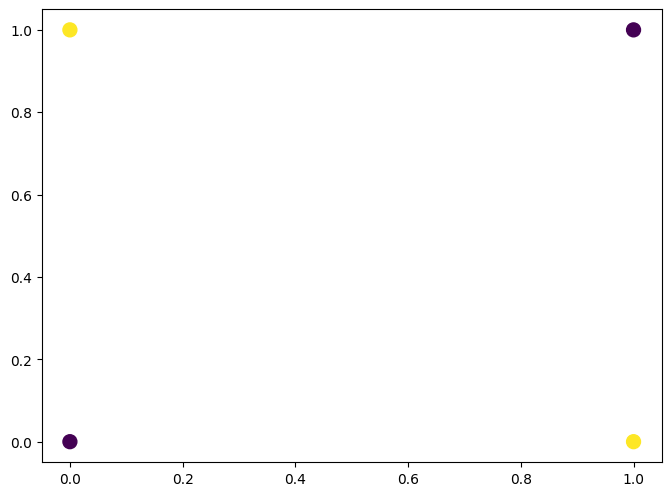

In [ ]:
## Data representing XOR
data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
labels = np.array([0, 1, 1, 0], dtype=np.float32)

plt.scatter(data[:,0], data[:,1], c=labels, cmap='viridis', s=100)
plt.show()

Now we construct neural networks to fit to this data.

In [ ]:
# Initialize a fully-connected network
def init_params(key, in_dim, out_dims: list):
  params = {}
  num_layers = len(out_dims)
  # Build up the layers iteratively
  for layer in range(num_layers):
    out_dim = out_dims[layer]
    key, subkey1, subkey2 = random.split(key, num=3)
    W = jax.nn.initializers.glorot_normal()(subkey1, (in_dim, out_dim))
    b = jax.nn.initializers.normal()(subkey2, (out_dim,))
    params["layer_{}".format(layer)] = {'W': W, 'b': b}
    in_dim = out_dim
  return params

@jit
def predict(params, inputs):
  # This is the forward pass where we calculate the outputs of each layer
  n_layers = len(params.keys())
  for i, layer in enumerate(params.keys()):
    W, b = params[layer].values()
    if i == n_layers:
      outputs = jnp.dot(inputs, W) + b
    # Apply this activation to the hidden layers
    else:
      outputs = jax.nn.tanh(jnp.dot(inputs, W) + b)
    inputs = outputs
  return jax.nn.sigmoid(outputs)

We'll use cross entropy for the loss function.

$$L = -y \log {\hat{y}} - (1-y) \log{(1-\hat{y}}) $$

In [ ]:
@jit
def cross_entropy(y_hat, y):
  return -y * jnp.log(y_hat) - (1 - y) * jnp.log(1 - y_hat)

@jit
def loss_fn(params, data, labels):
  predictions = predict(params, data)
  return jnp.mean(cross_entropy(predictions, labels))

@jit
def update(params, grads, alpha=0.1):
  # Gradient descent update
  return jax.tree_multimap(lambda p, g: p - alpha * g, params, grads)

For different choices of parameters we obtain different network architectures. For example we may want one or more hidden inner layers, or more neurons per hidden layer.

In [ ]:
# Network with no hidden layers
key = random.PRNGKey(0)
params = init_params(key, in_dim=2, out_dims=[1])
params

{'layer_0': {'W': DeviceArray([[ 1.0849862 ],
               [-0.03747887]], dtype=float32),
  'b': DeviceArray([0.00853552], dtype=float32)}}

In [ ]:
# Parameters for a network with one hidden layer with 10 neurons
key = random.PRNGKey(0)
params = init_params(key, in_dim=2, out_dims=[10, 1])
params

{'layer_0': {'W': DeviceArray([[-0.15334664, -0.57404345,  0.16896099,  0.0193229 ,
                 0.28093925,  0.16672899, -0.16986951,  0.24023007,
                -0.79107726,  0.567262  ],
               [ 0.00577271,  0.5408868 ,  0.45769197,  0.16919227,
                 0.39869374,  0.16878688, -0.2026505 , -0.62805575,
                 0.38477197, -0.20842196]], dtype=float32),
  'b': DeviceArray([ 1.48108061e-02, -1.62098883e-03,  1.09199807e-02,
               -2.43951454e-05, -6.89964928e-03, -9.08983592e-03,
                4.87750024e-03,  1.34845255e-02, -2.08340213e-03,
               -1.79609598e-03], dtype=float32)},
 'layer_1': {'W': DeviceArray([[-0.9655435 ],
               [-0.25068006],
               [ 0.23211278],
               [-0.04611349],
               [ 0.8049396 ],
               [ 0.11007237],
               [-0.46639663],
               [ 0.18001057],
               [ 0.27996314],
               [-0.45900962]], dtype=float32),
  'b': DeviceArray([0.0

We can use `grad` to compute the derivatives.

In [ ]:
# per example gradients
key = random.PRNGKey(0)
params = init_params(key, in_dim=2, out_dims=[1])
vmap(partial(grad(loss_fn), params))(data, labels)

{'layer_0': {'W': DeviceArray([[[ 0.        ],
                [ 0.        ]],
  
               [[-0.        ],
                [-0.5068086 ]],
  
               [[-0.11266375],
                [-0.        ]],
  
               [[ 0.264411  ],
                [ 0.264411  ]]], dtype=float32),
  'b': DeviceArray([[ 0.50209713],
               [-0.5068086 ],
               [-0.11266375],
               [ 0.264411  ]], dtype=float32)}}

First, we'll try to fit XOR with a one-layer network (i.e, no hidden layers) with gradient descent.

Text(0, 0.5, 'Cross entropy loss')

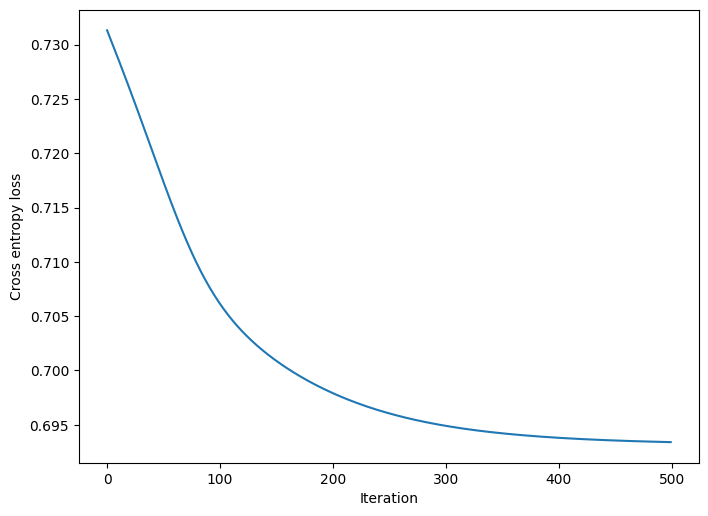

In [ ]:
tkey = random.PRNGKey(0)
params = init_params(key, in_dim=2, out_dims=[1])
loss_grad_fn = grad(loss_fn)
losses = []
iterations = 500
for i in range(iterations):
  grads = loss_grad_fn(params, data, labels)
  losses.append(loss_fn(params, data, labels))
  params = update(params, grads, alpha=.1)

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")

Plotting the predictions of the network on a grid, we find that we can't fit XOR. In hindsight, this is forseeable because the classes (0 and 1) are not linearly separable.

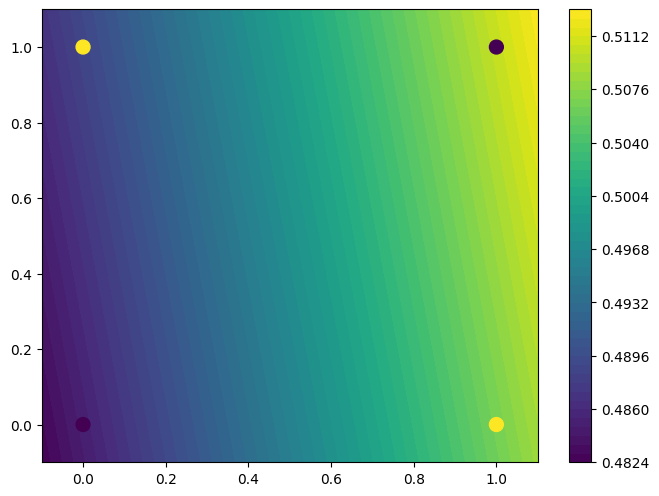

In [ ]:
fig, ax = plt.subplots()
xx, yy = np.mgrid[-.1:1.1:.01, -.1:1.1:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = predict(params, grid).reshape(xx.shape)
contour = ax.contourf(xx, yy, probs, levels=50)
fig.colorbar(contour)
ax.scatter(data[:,0], data[:,1], c=labels, s=100, cmap='viridis')
plt.show()

What about a two-layer network? With a two-layer neural network, we add a "hidden" layer between the input and output. The hidden layer applies an affine function to the input followed by a non-linear "activation" function (in this case, [hyperbolic tangent](https://en.wikipedia.org/wiki/Activation_function)).

Text(0, 0.5, 'Cross entropy loss')

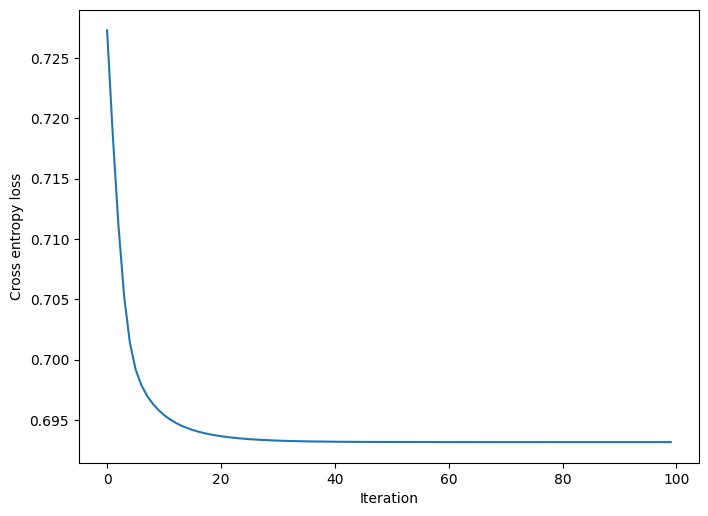

In [ ]:
key = random.PRNGKey(9)
params = init_params(key, in_dim=2, out_dims=[10, 1])
loss_grad_fn = grad(loss_fn)
losses = []
iterations = 100
for i in range(iterations):
  grads = loss_grad_fn(params, data, labels)
  losses.append(loss_fn(params, data, labels))
  params = update(params, grads, alpha=.8)

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Cross entropy loss")

Again, we plot the predictions of the network and find that this time we're able to correctly classify the points.

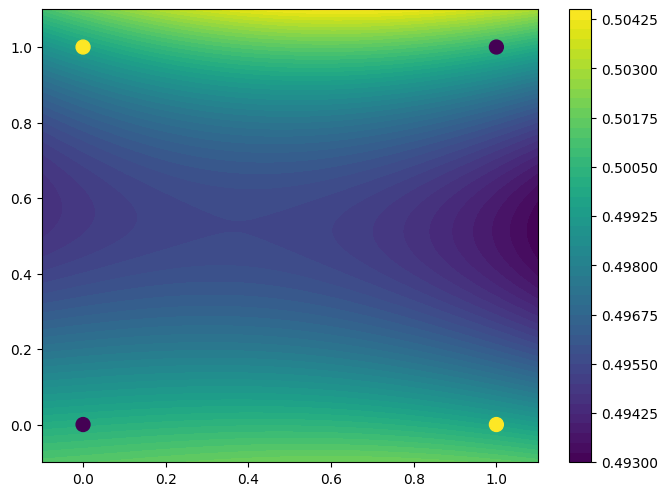

In [ ]:
fig, ax = plt.subplots()
xx, yy = np.mgrid[-.1:1.1:.01, -.1:1.1:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = predict(params, grid).reshape(xx.shape)
contour = ax.contourf(xx, yy, probs, levels=50)
fig.colorbar(contour)
ax.scatter(data[:,0], data[:,1], c=labels, s=100, cmap='viridis')
plt.show()